In [20]:
import kagglehub
omkarmanohardalvi_lungs_disease_dataset_4_types_path = kagglehub.dataset_download('omkarmanohardalvi/lungs-disease-dataset-4-types')

print('Data source import complete.')

Data source import complete.


In [21]:
# Import Libraries
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [22]:
# Define Paths
data_dir = '/kaggle/input/lungs-disease-dataset-4-types/Lung Disease Dataset/train'
test_dir = '/kaggle/input/lungs-disease-dataset-4-types/Lung Disease Dataset/test'

In [23]:
# Parameters
image_size = (224, 224)
batch_size = 32
num_classes = 5
num_folds = 5  # Number of folds for cross-validation
epochs_per_fold = 30

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
# Data Augmentation (Advanced)
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

In [26]:
# Validation & Test - No Augmentation
val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)

In [27]:
# Load Test Dataset
test_dataset = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 2025 images belonging to 5 classes.


In [28]:
# Prepare Data for K-Fold Cross-Validation
image_files = []
labels = []
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        for img_file in os.listdir(class_dir):
            image_files.append(os.path.join(class_dir, img_file))
            labels.append(class_name)

In [29]:
# Convert labels to numeric
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Create DataFrame
df = pd.DataFrame({'image_path': image_files, 'label': labels})

In [30]:
# Define K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

In [31]:
# Learning Rate Scheduler (Cosine Annealing)
def cosine_annealing(epoch):
    initial_lr = 1e-4  # Lower initial LR for Adam
    return initial_lr * 0.5 * (1 + math.cos(math.pi * epoch / epochs_per_fold))

In [32]:
def build_model():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze base layers

    inputs = Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [33]:
from sklearn.utils.class_weight import compute_class_weight

# Perform K-Fold Cross-Validation
best_test_acc = 0
best_model_path = ""
all_histories = []
all_test_preds = np.zeros((len(test_dataset.classes), num_classes))

# Convert labels back to string class names (ensure consistency)
df['label'] = label_encoder.inverse_transform(df['label'].values)

for fold, (train_idx, val_idx) in enumerate(skf.split(df['image_path'], df['label'])):
    print(f"Training Fold {fold + 1}/{num_folds}")

    # Create train/val DataFrames
    train_df = df.iloc[train_idx]
    val_df = df.iloc[val_idx]

    # Create Generators
    train_dataset_fold = train_datagen.flow_from_dataframe(
        train_df,
        x_col="image_path",
        y_col="label",
        target_size=image_size,
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=True
    )
    val_dataset_fold = val_datagen.flow_from_dataframe(
        val_df,
        x_col="image_path",
        y_col="label",
        target_size=image_size,
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=False
    )

    # ---- FIXED CLASS WEIGHTS ----
    # Extract labels as strings
    y_train = train_df['label'].astype(str).values
    class_labels = np.unique(y_train)

    # Compute class weights
    class_weights_array = compute_class_weight(
        class_weight='balanced',
        classes=class_labels,
        y=y_train
    )

    # Map string labels to class indices used by the generator
    class_indices = train_dataset_fold.class_indices  # e.g., {'cat': 0, 'dog': 1}
    class_weights_dict = {
        class_indices[label]: weight
        for label, weight in zip(class_labels, class_weights_array)
        if label in class_indices
    }

    # Build Model
    model = build_model()


Training Fold 1/5
Found 4843 validated image filenames belonging to 5 classes.
Found 1211 validated image filenames belonging to 5 classes.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training Fold 2/5
Found 4843 validated image filenames belonging to 5 classes.
Found 1211 validated image filenames belonging to 5 classes.
Training Fold 3/5
Found 4843 validated image filenames belonging to 5 classes.
Found 1211 validated image filenames belonging to 5 classes.
Training Fold 4/5
Found 4843 validated image filenames belonging to 5 classes.
Found 1211 validated image filenames belonging to 5 classes.
Training Fold 5/5
Found 4844 validated image filenames belonging to 5 classes.
Found 1210 validated image filenames belonging to 5 classes.


In [34]:


    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
    checkpoint = ModelCheckpoint(
        filepath=f'/kaggle/working/best_model_fold_{fold + 1}.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
    lr_scheduler = LearningRateScheduler(cosine_annealing)






    # Train Model
    history = model.fit(
        train_dataset_fold,
        epochs=epochs_per_fold,
        validation_data=val_dataset_fold,
        class_weight=class_weights_dict,
        callbacks=[early_stopping, reduce_lr, checkpoint, lr_scheduler]
    )
    all_histories.append(history)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 897ms/step - accuracy: 0.3372 - loss: 3.7409
Epoch 1: val_loss improved from inf to 1.09384, saving model to /kaggle/working/best_model_fold_5.keras
152/152 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step - accuracy: 0.3376 - loss: 3.7351 - val_accuracy: 0.5810 - val_loss: 1.0938 - learning_rate: 1.0000e-04
Epoch 2/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 733ms/step - accuracy: 0.5191 - loss: 1.5073
Epoch 2: val_loss improved from 1.09384 to 0.95478, saving model to /kaggle/working/best_model_fold_5.keras
152/152 ━━━━━━━━━━━━━━━━━━━━ 128s 829ms/step - accuracy: 0.5193 - loss: 1.5064 - val_accuracy: 0.5975 - val_loss: 0.9548 - learning_rate: 9.9726e-05
Epoch 3/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 730ms/step - accuracy: 0.5710 - loss: 1.0947
Epoch 3: val_loss improved from 0.95478 to 0.89516, saving model to /kaggle/working/best_model_fold_5.keras
152/152 ━━━━━━━━━━━━━━━━━━━━ 124s 818ms/step - accuracy: 0.5711 - loss: 1.0946 - val_accuracy: 0.6231 - val_loss: 0.8952 

In [35]:
    # Evaluate on Test Set
    model.load_weights(f"/kaggle/working/best_model_fold_{fold + 1}.keras")
    _, test_acc = model.evaluate(test_dataset)
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        best_model_path = f"/kaggle/working/best_model_fold_{fold + 1}.keras"

64/64 ━━━━━━━━━━━━━━━━━━━━ 35s 560ms/step - accuracy: 0.6670 - loss: 0.7544


In [36]:
    # Ensemble Predictions
    fold_preds = model.predict(test_dataset)
    all_test_preds += fold_preds

64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 480ms/step


In [37]:
# Final Test Evaluation (Using Best Model)
final_model = build_model()
final_model.load_weights(best_model_path)
final_loss, final_accuracy = final_model.evaluate(test_dataset)
print(f"\nBest Fold Model Test Accuracy: {final_accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


64/64 ━━━━━━━━━━━━━━━━━━━━ 38s 408ms/step - accuracy: 0.6670 - loss: 0.7544

Best Fold Model Test Accuracy: 0.7417


In [38]:
# Ensemble Final Predictions
final_preds = np.argmax(all_test_preds / num_folds, axis=1)

In [39]:
# Classification Report
print("\nFinal Classification Report (Ensemble):")
print(classification_report(test_dataset.classes, final_preds, target_names=test_dataset.class_indices.keys()))


Final Classification Report (Ensemble):
                      precision    recall  f1-score   support

 Bacterial Pneumonia       0.65      0.51      0.57       403
Corona Virus Disease       0.82      0.90      0.86       407
              Normal       0.69      0.86      0.77       404
        Tuberculosis       0.96      0.86      0.91       408
     Viral Pneumonia       0.59      0.58      0.58       403

            accuracy                           0.74      2025
           macro avg       0.74      0.74      0.74      2025
        weighted avg       0.74      0.74      0.74      2025



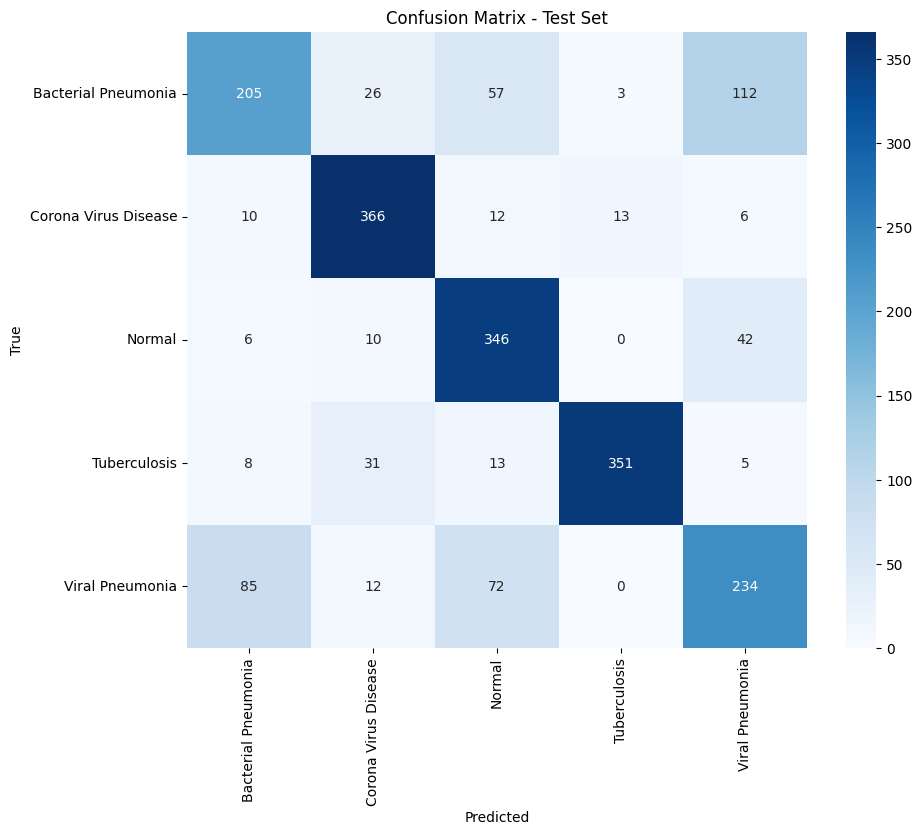

In [40]:
# Confusion Matrix
conf_matrix = confusion_matrix(test_dataset.classes, final_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.class_indices.keys(), yticklabels=test_dataset.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set')
plt.show()